# Gradient boosting (xgboost) with custom loss functions

See accompanying post: http://ytsaig.github.io/2016/01/03/tinkering.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.datasets.california_housing import fetch_california_housing

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Define custom loss functions (the gradients, actually)

In [3]:
def l2loss(preds, dtrain):
    labels = dtrain.get_label()
    grad = preds - labels
    hess = np.ones_like(grad)
    return grad, hess

def l1loss(preds, dtrain):
    labels = dtrain.get_label()
    grad = np.sign(preds - labels)
    hess = np.ones_like(grad)
    return grad, hess

def huberloss(alpha=90):
    def loss(preds, dtrain):
        labels = dtrain.get_label()
        diff = preds - labels
        delta = np.percentile(np.abs(diff), alpha)
        grad = diff
        grad[np.abs(diff) > delta] = delta*np.sign(diff[np.abs(diff) > delta])
        hess = np.ones_like(grad)
        return grad, hess
    
    return loss

### Read data and split 80/20 train/test

In [4]:
cal_housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data, np.log(cal_housing.target), test_size=0.2, random_state=1)
feature_names = cal_housing.feature_names

### Train xgboost model

In [5]:
# xgboost configuration
n_estimators = 1000
xgb_params = {'max_depth' : 3, 'eta' : 0.05, 'seed' : 12345, 'silent' : 1}

In [6]:
# Create DMatrix objects for xgboost
dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, y_test, feature_names=feature_names)

In [7]:
# Train models
models = [xgb.train(xgb_params, dtrain, n_estimators, obj=o) for o in (l2loss, l1loss, huberloss(90))]

### Plot train/test error curves for l2 loss

In [8]:
# Generate incremental predictions
model = models[0]
errors = []
for nt in range(1, n_estimators+1):
    pred_train = model.predict(dtrain, ntree_limit=nt)
    pred_test = model.predict(dtest, ntree_limit=nt)
    errors.append((mean_absolute_error(y_train, pred_train), mean_absolute_error(y_test, pred_test)))

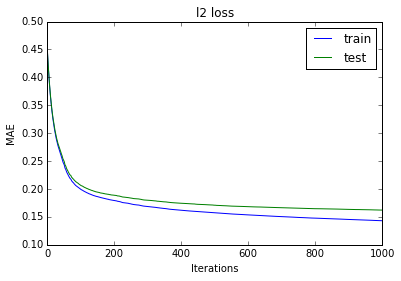

In [9]:
# Plot error curves
pd.DataFrame(errors, columns=['train', 'test']).plot(title='l2 loss')
plt.xlabel('Iterations')
plt.ylabel('MAE');

### Compare test set errors for the 3 loss functions

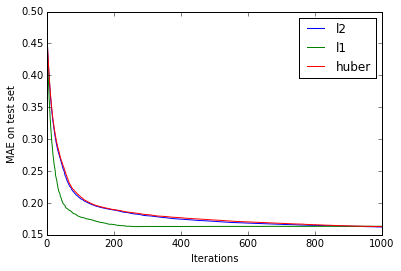

In [10]:
steps =  range(1, n_estimators+1)
mae = [[mean_absolute_error(y_test, m.predict(dtest, ntree_limit=nt)) for m in models] for nt in steps]
pd.DataFrame(mae, columns=['l2', 'l1', 'huber'], index=steps).plot()
plt.xlabel('Iterations')
plt.ylabel('MAE on test set');

### Simulate outliers in the response

In [11]:
def add_outliers(y, frac=0.01, dist=5.0):
    """Add noise to a fraction of samples in the vector y, sampled from a bimodal distribution."""
    sd = np.std(y)
    ind = np.random.choice(len(y), frac*len(y), replace=False)
    yo = y.copy()
    yo[ind] = yo[ind] + np.sign(np.random.normal(size=len(ind))) * np.random.normal(loc=dist*sd, scale=sd, size=len(ind))
    return yo

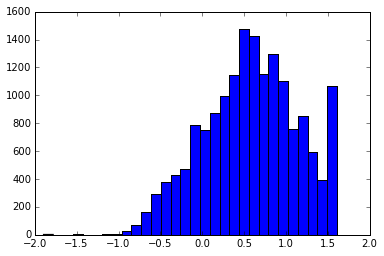

In [12]:
plt.hist(y_train, 30);

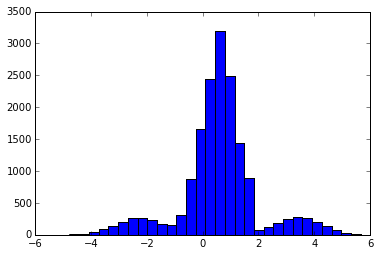

In [13]:
plt.hist(add_outliers(y_train, 0.2), 30);

In [14]:
fracs = np.arange(0.0, 0.8, 0.01)
mae = []
for frac in fracs:
    # Add outliers to training data
    dtrain_corrupt = xgb.DMatrix(X_train, add_outliers(y_train, frac=frac, dist=5.0), feature_names=feature_names)
    # Train models
    models = [xgb.train(xgb_params, dtrain_corrupt, n_estimators, obj=o) for o in (l2loss, l1loss, huberloss(90), huberloss(80))]
    # Compute validation errors    
    mae.append([mean_absolute_error(y_test, m.predict(dtest)) for m in models])

### Compare test set error of the different loss functions for increasing outlier level

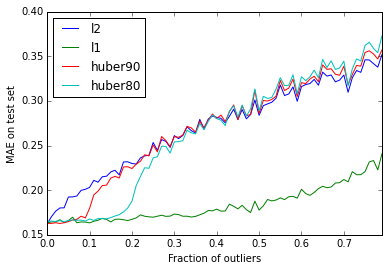

In [15]:
pd.DataFrame(mae, columns=['l2', 'l1', 'huber90', 'huber80'], index=fracs).plot()
plt.xlabel('Fraction of outliers')
plt.ylabel('MAE on test set');

## Custom loss with autograd

In [16]:
# Need autograd's numpy wrapper 
import autograd.numpy as np
from autograd import grad

In [17]:
def l2_obj(x):
    return 0.5 * np.sum(x ** 2)

def l2autograd(preds, dtrain):
    labels = dtrain.get_label()
    grad_l2obj = grad(l2_obj)
    g = grad_l2obj(preds - labels)
    h = np.ones_like(g)
    return g, h

def l1_obj(x):
    return np.sum(np.abs(x))

def l1autograd(preds, dtrain):
    labels = dtrain.get_label()
    grad_l1obj = grad(l1_obj)
    g = grad_l1obj(preds - labels)
    # Handle nan's in the gradient
    g[np.isnan(g)] = 0
    h = np.ones_like(g)
    return g, h

def huberobj(delta):
    def obj(x):
        return 0.5*np.sum(np.where(np.abs(x) <= delta, (x) ** 2, 2*delta*np.abs(x) - delta**2))
    return obj

def huberautograd(alpha=90):
    def loss(preds, dtrain):
        labels = dtrain.get_label()
        e = preds - labels
        delta = np.percentile(np.abs(e), alpha)
        obj = huberobj(delta)
        obj_autograd = grad(obj)
        g = obj_autograd(e)
        # Handle nan's in the gradient
        g[np.isnan(g)] = 0
        h = np.ones_like(g)
        return g, h
    return loss

In [18]:
# Train models using l2 loss
models = [xgb.train(xgb_params, dtrain, n_estimators, obj=o) for o in (l2loss, l2autograd)]
# Test that we get the same thing
preds = [m.predict(dtest) for m in models]
print mean_absolute_error(preds[0], preds[1])

0.0


In [20]:
# Train models using l1 loss
models = [xgb.train(xgb_params, dtrain, n_estimators, obj=o) for o in (l1loss, l1autograd)]
# Test that we get the same thing
preds = [m.predict(dtest) for m in models]
mean_absolute_error(preds[0], preds[1])

0.0

In [21]:
# Train models using huber loss
models = [xgb.train(xgb_params, dtrain, n_estimators, obj=o) for o in (huberloss(90), huberautograd(90))]
# Test that we get the same thing
preds = [m.predict(dtest) for m in models]
mean_absolute_error(preds[0], preds[1])

0.0

## Performance benchmarks

In [22]:
n_estimators = 1000
xgb_params = {'max_depth' : 6, 'eta' : 0.05, 'seed' : 12345, 'silent' : 1}

In [23]:
print('Built in l2 loss.\n')
%timeit xgb.train(xgb_params, dtrain, n_estimators)

print('l2 loss with analytical gradient.\n')
%timeit xgb.train(xgb_params, dtrain, n_estimators, obj=l2loss)

print('l2 loss with autograd.\n')
%timeit xgb.train(xgb_params, dtrain, n_estimators, obj=l2autograd)

Built in l2 loss.

1 loops, best of 3: 4.12 s per loop
l2 loss with analytical gradient.

1 loops, best of 3: 13.3 s per loop
l2 loss with autograd.

1 loops, best of 3: 13.8 s per loop
